Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from collections import Counter

Data Understanding

In [2]:
# Memuat Dataset

df = pd.read_csv('../dataset/diabetes_dataset.csv')
df.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
7,Female,79.0,0,0,No Info,23.86,5.7,85,0
8,Male,42.0,0,0,never,33.64,4.8,145,0
9,Female,32.0,0,0,never,27.32,5.0,100,0


In [3]:
# Mengecek Jumlah Data

total = df.shape[0]
print("Jumlah data:", total)

Jumlah data: 100000


In [4]:
# Mengecek Missing Values

df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [5]:
# Mengecek Duplicate Values

dv = df.duplicated().sum()
print("Jumlah data duplikat:", dv)

Jumlah data duplikat: 3854


In [6]:
# Mengecek Outliers

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

numerical_columns = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]
outliers_iqr = {col: detect_outliers_iqr(df, col) for col in numerical_columns}
outlier_counts = {col: {"IQR": len(outliers_iqr[col])} for col in numerical_columns}

print("Jumlah outlier yang terdeteksi:")
for col, counts in outlier_counts.items():
    print(f"{col}: IQR = {counts['IQR']}")

Jumlah outlier yang terdeteksi:
age: IQR = 0
bmi: IQR = 7086
HbA1c_level: IQR = 1315
blood_glucose_level: IQR = 2038


In [7]:
# Mengecek Tipe Data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [8]:
# Encode Numeric Label

diabetes_mapping = {0: "Negatif Diabetes", 1: "Positif Diabetes"}
hypertension = {0: "Tidak", 1: "Ya"}
heart_disease_mapping = {0: "Tidak", 1: "Ya"}

df["diabetes"] = df["diabetes"].map(diabetes_mapping)
df["hypertension"] = df["hypertension"].map(hypertension)
df["heart_disease"] = df["heart_disease"].map(heart_disease_mapping)

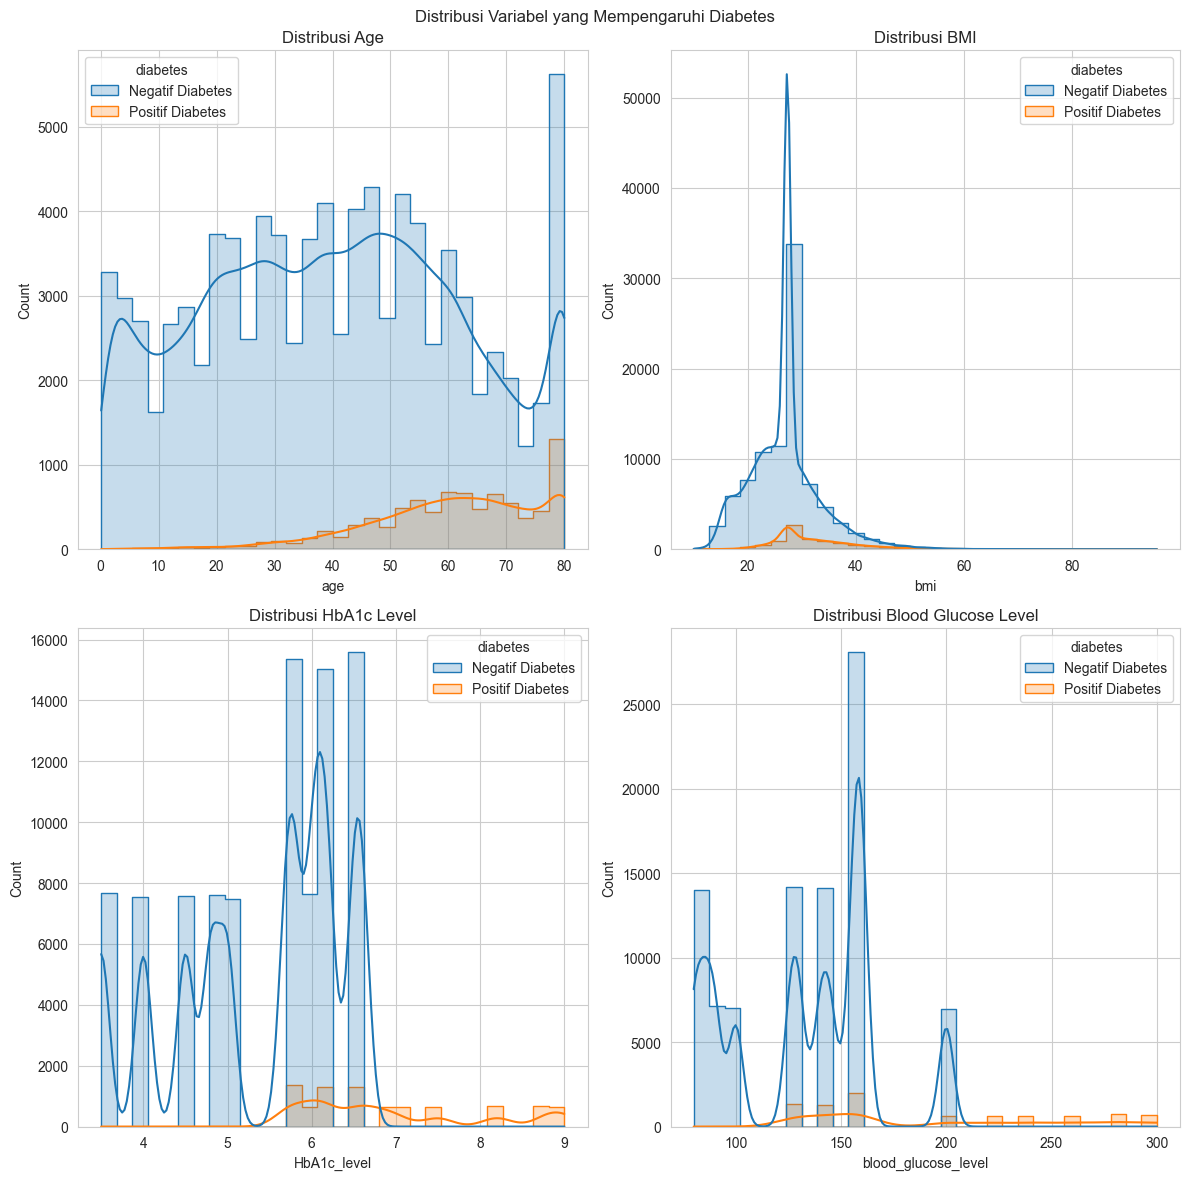

In [9]:
# Set style seaborn
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Distribusi Variabel yang Mempengaruhi Diabetes")

# Distribusi Usia
sns.histplot(df, x="age", hue="diabetes", bins=30, kde=True, element="step", ax=axes[0, 0])
axes[0, 0].set_title("Distribusi Age")

# Distribusi BMI
sns.histplot(df, x="bmi", hue="diabetes", bins=30, kde=True, element="step", ax=axes[0, 1])
axes[0, 1].set_title("Distribusi BMI")

# Distribusi HbA1c Level
sns.histplot(df, x="HbA1c_level", hue="diabetes", bins=30, kde=True, element="step", ax=axes[1, 0])
axes[1, 0].set_title("Distribusi HbA1c Level")

# Distribusi Blood Glucose Level
sns.histplot(df, x="blood_glucose_level", hue="diabetes", bins=30, kde=True, element="step", ax=axes[1, 1])
axes[1, 1].set_title("Distribusi Blood Glucose Level")

plt.tight_layout()
plt.show()


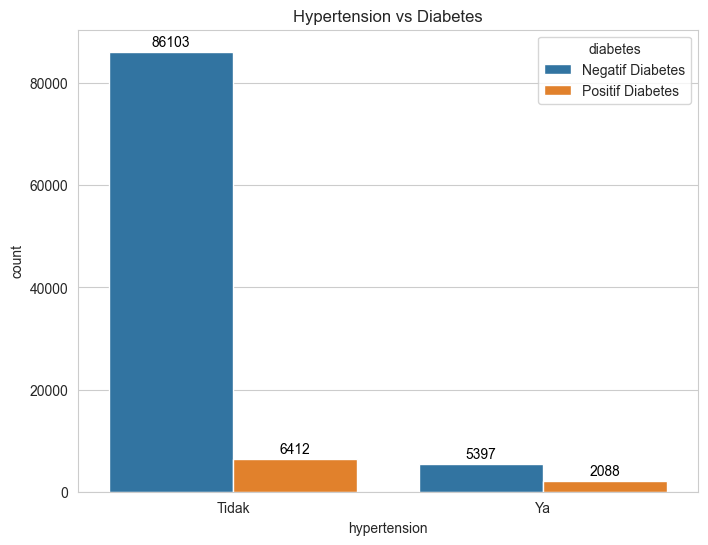

In [10]:
# Hypertension vs Diabetes

plt.figure(figsize=(8, 6))
ax_hypertension = sns.countplot(data=df, x="hypertension", hue="diabetes")
plt.title("Hypertension vs Diabetes")

for p in ax_hypertension.patches:
    if p.get_height() > 0: 
        ax_hypertension.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 2), textcoords='offset points')
        
plt.show()


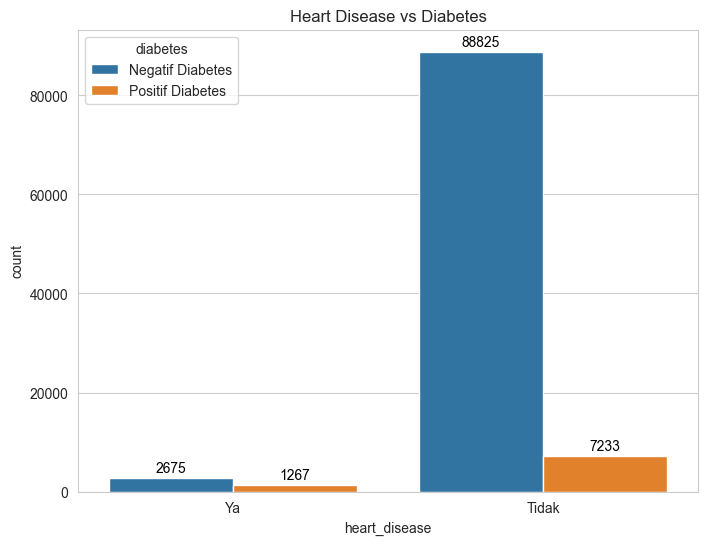

In [11]:
# Heart Disease vs Diabetes

plt.figure(figsize=(8, 6))
ax_heart_disease = sns.countplot(data=df, x="heart_disease", hue="diabetes")
plt.title("Heart Disease vs Diabetes")

for p in ax_heart_disease.patches:
    if p.get_height() > 0: 
        ax_heart_disease.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 2), textcoords='offset points')

plt.show()


Data Preparation

In [12]:
# Pembersihan Data - Remove Duplicates

df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [13]:
# Pembersihan Data - Remove Outliers

def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

df_cleaned = df.copy()
for col in numerical_columns:
    df_cleaned = remove_outliers_iqr(df_cleaned, col)

print(f"Jumlah data setelah menghapus outlier: {len(df_cleaned)}")

Jumlah data setelah menghapus outlier: 88195


In [14]:
# Encode Categorical Variables

label_encoder = {}
for col in ['gender', 'smoking_history', 'hypertension', 'heart_disease', 'diabetes']:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoder[col] = le
    
df_cleaned.head(10) 

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,4,25.19,6.6,140,0
1,0,54.0,0,0,0,27.32,6.6,80,0
2,1,28.0,0,0,4,27.32,5.7,158,0
3,0,36.0,0,0,1,23.45,5.0,155,0
4,1,76.0,1,1,1,20.14,4.8,155,0
5,0,20.0,0,0,4,27.32,6.6,85,0
6,0,44.0,0,0,4,19.31,6.5,200,1
7,0,79.0,0,0,0,23.86,5.7,85,0
8,1,42.0,0,0,4,33.64,4.8,145,0
9,0,32.0,0,0,4,27.32,5.0,100,0


In [15]:
# Simpan Label Encoder

joblib.dump(label_encoder, "../utils/label_encoder.pkl")

print("Label Encoder berhasil disimpan!")

Label Encoder berhasil disimpan!


In [16]:
# Membagi Features and Target

X = df_cleaned.drop('diabetes', axis=1)
y = df_cleaned['diabetes']

In [17]:
# Melakukan Oversampling

print("Distribusi sebelum SMOTE:", Counter(y))
smote = SMOTE()
X, y = smote.fit_resample(X, y)
print("Distribusi setelah SMOTE:", Counter(y))

Distribusi sebelum SMOTE: Counter({0: 83577, 1: 4618})
Distribusi setelah SMOTE: Counter({0: 83577, 1: 83577})


In [18]:
# Membagi Dataset - Train Test Split (80:20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Simpan Data Train dan Test

joblib.dump(X_test, "../utils/X_test.pkl")
joblib.dump(y_test, "../utils/y_test.pkl")

print("Data Train dan Test berhasil disimpan!")

Data Train dan Test berhasil disimpan!


Modeling

In [20]:
# Inisialisasi Model

knn_model = KNeighborsClassifier(n_neighbors=5)
svc_model = SVC(C=1.0, random_state=42)

In [21]:
# Training Model

y_pred_knn = knn_model.fit(X_train, y_train).predict(X_test)
y_pred_svc = svc_model.fit(X_train, y_train).predict(X_test)

Evaluation

In [22]:
# Evaluasi Model

accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_svc = accuracy_score(y_test, y_pred_svc)

print(f"Accuracy KNN: {accuracy_knn:.4f}")
print(f"Accuracy SVM: {accuracy_svc:.4f}")

print(f"\nClassification Report KNN:\n{classification_report(y_test, y_pred_knn)}")
print(f"Classification Report SVM:\n{classification_report(y_test, y_pred_svc)}")

Accuracy KNN: 0.9334
Accuracy SVM: 0.8770

Classification Report KNN:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     16564
           1       0.89      0.99      0.94     16867

    accuracy                           0.93     33431
   macro avg       0.94      0.93      0.93     33431
weighted avg       0.94      0.93      0.93     33431

Classification Report SVM:
              precision    recall  f1-score   support

           0       0.92      0.82      0.87     16564
           1       0.84      0.93      0.88     16867

    accuracy                           0.88     33431
   macro avg       0.88      0.88      0.88     33431
weighted avg       0.88      0.88      0.88     33431



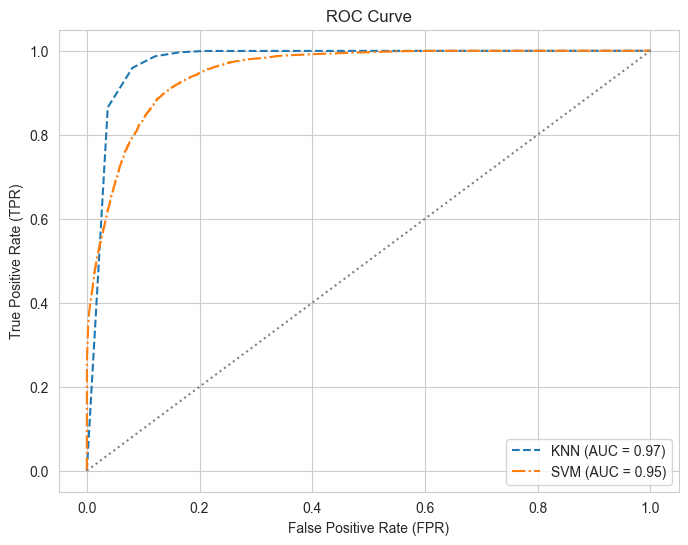

In [23]:
# ROC & AUC Curve

n_classes = len(set(y_test))
if n_classes > 2:
    y_test_bin = LabelBinarizer(y_test, classes=list(set(y_test)))
else:
    y_test_bin = y_test

y_score_knn = knn_model.predict_proba(X_test)[:, 1]
y_score_svc = svc_model.decision_function(X_test)

fpr_knn, tpr_knn, _ = roc_curve(y_test_bin, y_score_knn)
fpr_svc, tpr_svc, _ = roc_curve(y_test_bin, y_score_svc)

auc_knn = auc(fpr_knn, tpr_knn)
auc_svc = auc(fpr_svc, tpr_svc)

# Visualisasi ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.2f})', linestyle='--')
plt.plot(fpr_svc, tpr_svc, label=f'SVM (AUC = {auc_svc:.2f})', linestyle='-.')

plt.plot([0, 1], [0, 1], color='gray', linestyle='dotted')

# Pengaturan plot
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


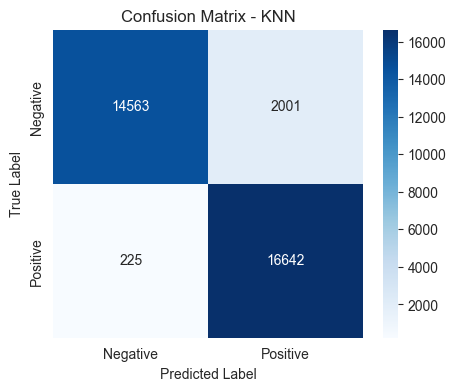

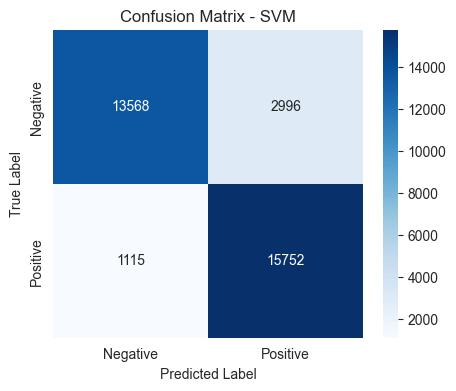

In [24]:
# Confusion Matrix

cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_svc = confusion_matrix(y_test, y_pred_svc)

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

plot_confusion_matrix(cm_knn, "KNN")
plot_confusion_matrix(cm_svc, "SVM")

Deployment

In [25]:
# Mecari Model Terbaik

best_model = max(
    [(knn_model, accuracy_knn, "KNN"), 
    (svc_model, accuracy_svc, "SVM")], 
    key=lambda x: x[1]
)

In [26]:
# Menyimpan Model Terbaik dan Label Encoder

best_model_name = f"{best_model[2]}_best_model.pkl"
best_model_path = os.path.join("../model", best_model_name)

joblib.dump(best_model[0], best_model_path)
joblib.dump(svc_model, "../model/SVM_model.pkl")

print(f"Model terbaik ({best_model[2]}) dengan akurasi {best_model[1]:.4f} telah disimpan sebagai {best_model_name}")
print(f"Model lain (SVM) dengan akurasi {accuracy_svc:.4f} telah disimpan sebagai SVM_model.pkl")

Model terbaik (KNN) dengan akurasi 0.9334 telah disimpan sebagai KNN_best_model.pkl
Model lain (SVM) dengan akurasi 0.8770 telah disimpan sebagai SVM_model.pkl


In [27]:
# Memuat Model Terbaik dan Label Encoder

best_model_path = "../model/KNN_best_model.pkl" 
label_encoder_path = "../utils/label_encoder.pkl"

loaded_model = joblib.load(best_model_path)
loaded_label = joblib.load(label_encoder_path)

In [28]:
# Uji Input Data

# Female 44.0 0	0 never	19.31 6.5 200 1
# Male 67.0 0 1 not current 27.32 6.5 200 1
# Female 53.0 0 0 No Info 31.75 4.0 200 0
# Male 76.0	1 1	current	20.14 4.8 155 0

input_data = {
    "gender": "Female",  # "Male" atau "Female"
    "age": 53.0,  # Usia dalam tahun
    "hypertension": 0,  # 0 = Tidak, 1 = Ya
    "heart_disease": 0,  # 0 = Tidak, 1 = Ya
    "smoking_history": "No Info",  # Kategori: "No Info", "never", "former", "current", "not current".
    "bmi": 31.75,  # Indeks Massa Tubuh
    "HbA1c_level": 4.0,  # Kadar HbA1c
    "blood_glucose_level": 155  # Kadar glukosa darah
}

input_data["gender"] = loaded_label["gender"].transform([input_data["gender"]])[0]
input_data["smoking_history"] = loaded_label["smoking_history"].transform([input_data["smoking_history"]])[0]

input_array = np.array([
    input_data["gender"],
    input_data["age"],
    input_data["hypertension"],
    input_data["heart_disease"],
    input_data["smoking_history"],
    input_data["bmi"],
    input_data["HbA1c_level"],
    input_data["blood_glucose_level"]
]).reshape(1, -1)

prediction = loaded_model.predict(input_array)

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [29]:
result = "Positif Diabetes" if prediction[0] == 1 else "Negatif Diabetes"

if prediction[0] == 1:
    interpretation = "Model memprediksi bahwa Anda memiliki kemungkinan mengalami diabetes."
    follow_up = """
    **Rekomendasi:**
    1. **Konsultasi dengan Dokter:** Lakukan pemeriksaan lebih lanjut untuk konfirmasi.
    2. **Pantau Pola Makan:** Kurangi asupan gula dan perbanyak makanan tinggi serat.
    3. **Olahraga Rutin:** Aktivitas fisik seperti jalan cepat, jogging, atau bersepeda sangat dianjurkan.
    4. **Cek Kesehatan Rutin:** Pantau kadar HbA1c dan glukosa darah secara berkala.
    """
else:
    interpretation = "Model memprediksi bahwa Anda tidak memiliki diabetes."
    follow_up = """
    **Rekomendasi:**
    1. **Tetap Jaga Pola Hidup Sehat:** Konsumsi makanan seimbang dan rutin berolahraga.
    2. **Cek Kesehatan Secara Berkala:** Pastikan kadar gula darah dalam rentang normal.
    3. **Kelola Stres:** Hindari stres berlebihan yang bisa berdampak pada kesehatan.
    """

print(f"Hasil Prediksi: {result}")
print(f"Interpretasi: {interpretation}")
print(f"{follow_up}")

Hasil Prediksi: Negatif Diabetes
Interpretasi: Model memprediksi bahwa Anda tidak memiliki diabetes.

    **Rekomendasi:**
    1. **Tetap Jaga Pola Hidup Sehat:** Konsumsi makanan seimbang dan rutin berolahraga.
    2. **Cek Kesehatan Secara Berkala:** Pastikan kadar gula darah dalam rentang normal.
    3. **Kelola Stres:** Hindari stres berlebihan yang bisa berdampak pada kesehatan.
    
